# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed-celeba-small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform)
    
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

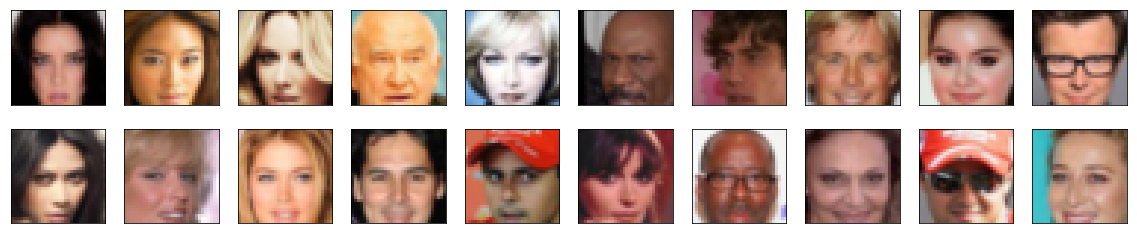

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max-min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8196)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv0 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv1 = conv(conv_dim, conv_dim*2, 4)
        self.conv2 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv3 = conv(conv_dim*4, conv_dim*8, 4)
        
        self.fc = nn.Linear(conv_dim*8*2*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, self.conv_dim*8*2*2)
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(transpose_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        self.conv0 = deconv(conv_dim*8, conv_dim*4, 4)
        self.conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.tanh(self.conv3(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/vsalova/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (conv0): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    
    if train_on_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.99

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # 1. Train the discriminator on real and fake images
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            

            g_optimizer.zero_grad()

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            D_fake = D(fake_images)


            # 2. Train the generator with an adversarial loss
            g_loss = real_loss(D_fake) 

            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.3035 | g_loss: 1.2008
Epoch [    1/   30] | d_loss: 0.1723 | g_loss: 5.3335
Epoch [    1/   30] | d_loss: 1.0230 | g_loss: 6.0686
Epoch [    1/   30] | d_loss: 0.7776 | g_loss: 3.1233
Epoch [    1/   30] | d_loss: 0.5092 | g_loss: 3.0341
Epoch [    1/   30] | d_loss: 0.7257 | g_loss: 4.2937
Epoch [    1/   30] | d_loss: 0.6450 | g_loss: 2.7439
Epoch [    1/   30] | d_loss: 0.9195 | g_loss: 2.2129
Epoch [    1/   30] | d_loss: 0.6872 | g_loss: 3.4811
Epoch [    1/   30] | d_loss: 0.6354 | g_loss: 3.0880
Epoch [    1/   30] | d_loss: 0.9765 | g_loss: 3.5364
Epoch [    1/   30] | d_loss: 0.5919 | g_loss: 2.3279
Epoch [    1/   30] | d_loss: 1.0929 | g_loss: 3.1793
Epoch [    1/   30] | d_loss: 0.7021 | g_loss: 2.8188
Epoch [    1/   30] | d_loss: 0.6034 | g_loss: 2.5594
Epoch [    1/   30] | d_loss: 0.6935 | g_loss: 3.7311
Epoch [    1/   30] | d_loss: 0.6506 | g_loss: 1.9715
Epoch [    1/   30] | d_loss: 1.0547 | g_loss: 2.4572
Epoch [    1/   30] | d_loss

Epoch [    2/   30] | d_loss: 0.6725 | g_loss: 2.1245
Epoch [    2/   30] | d_loss: 0.6004 | g_loss: 1.6411
Epoch [    2/   30] | d_loss: 0.4936 | g_loss: 2.0537
Epoch [    2/   30] | d_loss: 0.5069 | g_loss: 2.2789
Epoch [    2/   30] | d_loss: 0.4144 | g_loss: 0.7178
Epoch [    2/   30] | d_loss: 0.5908 | g_loss: 2.6112
Epoch [    2/   30] | d_loss: 0.7838 | g_loss: 2.0486
Epoch [    2/   30] | d_loss: 1.3754 | g_loss: 1.7995
Epoch [    2/   30] | d_loss: 0.3418 | g_loss: 1.9308
Epoch [    2/   30] | d_loss: 0.5591 | g_loss: 1.7777
Epoch [    2/   30] | d_loss: 0.7807 | g_loss: 2.0596
Epoch [    2/   30] | d_loss: 0.7578 | g_loss: 3.3557
Epoch [    2/   30] | d_loss: 0.5082 | g_loss: 2.6499
Epoch [    2/   30] | d_loss: 0.9453 | g_loss: 5.0551
Epoch [    2/   30] | d_loss: 0.9898 | g_loss: 2.3660
Epoch [    2/   30] | d_loss: 0.6394 | g_loss: 2.7532
Epoch [    2/   30] | d_loss: 0.6143 | g_loss: 1.3865
Epoch [    2/   30] | d_loss: 0.4889 | g_loss: 1.8295
Epoch [    2/   30] | d_loss

Epoch [    4/   30] | d_loss: 0.1290 | g_loss: 3.2331
Epoch [    4/   30] | d_loss: 0.8236 | g_loss: 1.5231
Epoch [    4/   30] | d_loss: 0.6477 | g_loss: 2.3033
Epoch [    4/   30] | d_loss: 0.4045 | g_loss: 0.5473
Epoch [    4/   30] | d_loss: 0.3680 | g_loss: 2.6894
Epoch [    4/   30] | d_loss: 0.8556 | g_loss: 1.7227
Epoch [    4/   30] | d_loss: 0.3889 | g_loss: 2.5859
Epoch [    4/   30] | d_loss: 0.8650 | g_loss: 1.7337
Epoch [    4/   30] | d_loss: 0.6446 | g_loss: 2.8719
Epoch [    4/   30] | d_loss: 0.3577 | g_loss: 1.6375
Epoch [    4/   30] | d_loss: 0.1689 | g_loss: 2.6599
Epoch [    4/   30] | d_loss: 0.9153 | g_loss: 3.2526
Epoch [    4/   30] | d_loss: 0.8049 | g_loss: 2.2004
Epoch [    4/   30] | d_loss: 0.4114 | g_loss: 1.6043
Epoch [    4/   30] | d_loss: 0.4088 | g_loss: 1.8411
Epoch [    4/   30] | d_loss: 0.2117 | g_loss: 3.7188
Epoch [    4/   30] | d_loss: 0.8320 | g_loss: 1.5747
Epoch [    4/   30] | d_loss: 0.2430 | g_loss: 2.8756
Epoch [    4/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.3591 | g_loss: 3.1237
Epoch [    6/   30] | d_loss: 0.6868 | g_loss: 0.7080
Epoch [    6/   30] | d_loss: 0.3405 | g_loss: 1.7568
Epoch [    6/   30] | d_loss: 0.3817 | g_loss: 2.6058
Epoch [    6/   30] | d_loss: 0.2585 | g_loss: 2.3652
Epoch [    6/   30] | d_loss: 0.8743 | g_loss: 5.2326
Epoch [    6/   30] | d_loss: 0.4999 | g_loss: 2.1111
Epoch [    6/   30] | d_loss: 0.2432 | g_loss: 3.0527
Epoch [    6/   30] | d_loss: 0.7951 | g_loss: 3.6850
Epoch [    6/   30] | d_loss: 0.7629 | g_loss: 1.1805
Epoch [    6/   30] | d_loss: 0.7767 | g_loss: 1.0129
Epoch [    6/   30] | d_loss: 0.6161 | g_loss: 1.6004
Epoch [    6/   30] | d_loss: 0.5360 | g_loss: 1.9100
Epoch [    6/   30] | d_loss: 0.0846 | g_loss: 4.3354
Epoch [    6/   30] | d_loss: 0.2712 | g_loss: 6.3530
Epoch [    6/   30] | d_loss: 0.3816 | g_loss: 2.1712
Epoch [    6/   30] | d_loss: 0.6115 | g_loss: 5.8586
Epoch [    6/   30] | d_loss: 1.0887 | g_loss: 1.4091
Epoch [    6/   30] | d_loss

Epoch [    7/   30] | d_loss: 0.2771 | g_loss: 2.0638
Epoch [    7/   30] | d_loss: 0.6550 | g_loss: 3.6071
Epoch [    7/   30] | d_loss: 0.5987 | g_loss: 1.7355
Epoch [    7/   30] | d_loss: 0.3932 | g_loss: 4.8133
Epoch [    7/   30] | d_loss: 0.3521 | g_loss: 4.2637
Epoch [    7/   30] | d_loss: 0.2419 | g_loss: 2.0063
Epoch [    7/   30] | d_loss: 1.4469 | g_loss: 0.5004
Epoch [    7/   30] | d_loss: 1.0466 | g_loss: 3.9859
Epoch [    7/   30] | d_loss: 0.0673 | g_loss: 1.0789
Epoch [    7/   30] | d_loss: 0.6589 | g_loss: 2.8832
Epoch [    7/   30] | d_loss: 0.6203 | g_loss: 2.0025
Epoch [    7/   30] | d_loss: 0.6666 | g_loss: 4.3226
Epoch [    7/   30] | d_loss: 0.5520 | g_loss: 3.5871
Epoch [    7/   30] | d_loss: 0.1647 | g_loss: 2.8792
Epoch [    7/   30] | d_loss: 1.1605 | g_loss: 2.9022
Epoch [    7/   30] | d_loss: 0.3336 | g_loss: 2.4769
Epoch [    7/   30] | d_loss: 0.8562 | g_loss: 3.0725
Epoch [    7/   30] | d_loss: 0.1503 | g_loss: 6.9987
Epoch [    7/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.1425 | g_loss: 5.0257
Epoch [    9/   30] | d_loss: 0.3728 | g_loss: 3.2607
Epoch [    9/   30] | d_loss: 0.0756 | g_loss: 3.6884
Epoch [    9/   30] | d_loss: 0.2050 | g_loss: 4.5484
Epoch [    9/   30] | d_loss: 0.7273 | g_loss: 0.8290
Epoch [    9/   30] | d_loss: 0.6440 | g_loss: 0.2849
Epoch [    9/   30] | d_loss: 0.3006 | g_loss: 2.4777
Epoch [    9/   30] | d_loss: 0.2774 | g_loss: 1.2504
Epoch [    9/   30] | d_loss: 0.6499 | g_loss: 3.3428
Epoch [    9/   30] | d_loss: 0.3664 | g_loss: 4.5940
Epoch [    9/   30] | d_loss: 0.1258 | g_loss: 2.9858
Epoch [    9/   30] | d_loss: 0.2727 | g_loss: 4.9616
Epoch [    9/   30] | d_loss: 0.1322 | g_loss: 2.8040
Epoch [    9/   30] | d_loss: 0.7553 | g_loss: 3.8732
Epoch [    9/   30] | d_loss: 0.3206 | g_loss: 4.8637
Epoch [    9/   30] | d_loss: 0.1573 | g_loss: 4.3877
Epoch [    9/   30] | d_loss: 0.0431 | g_loss: 4.9627
Epoch [    9/   30] | d_loss: 0.0551 | g_loss: 4.3022
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.2533 | g_loss: 5.2369
Epoch [   11/   30] | d_loss: 0.1106 | g_loss: 5.3643
Epoch [   11/   30] | d_loss: 0.3346 | g_loss: 1.9938
Epoch [   11/   30] | d_loss: 0.1974 | g_loss: 2.9955
Epoch [   11/   30] | d_loss: 0.7546 | g_loss: 1.3307
Epoch [   11/   30] | d_loss: 0.0774 | g_loss: 3.3228
Epoch [   11/   30] | d_loss: 0.2610 | g_loss: 1.4163
Epoch [   11/   30] | d_loss: 0.6281 | g_loss: 3.0729
Epoch [   11/   30] | d_loss: 0.1514 | g_loss: 2.3650
Epoch [   11/   30] | d_loss: 0.7917 | g_loss: 1.7079
Epoch [   11/   30] | d_loss: 0.5767 | g_loss: 2.3625
Epoch [   11/   30] | d_loss: 0.1234 | g_loss: 5.7240
Epoch [   11/   30] | d_loss: 0.1043 | g_loss: 8.0793
Epoch [   11/   30] | d_loss: 0.4522 | g_loss: 2.1844
Epoch [   11/   30] | d_loss: 0.0485 | g_loss: 4.8002
Epoch [   11/   30] | d_loss: 0.1752 | g_loss: 4.2822
Epoch [   11/   30] | d_loss: 0.2419 | g_loss: 2.2612
Epoch [   11/   30] | d_loss: 1.7047 | g_loss: 2.1188
Epoch [   11/   30] | d_loss

Epoch [   12/   30] | d_loss: 0.5838 | g_loss: 3.9823
Epoch [   12/   30] | d_loss: 0.8811 | g_loss: 4.1428
Epoch [   12/   30] | d_loss: 0.2255 | g_loss: 2.7891
Epoch [   12/   30] | d_loss: 0.2610 | g_loss: 3.9751
Epoch [   12/   30] | d_loss: 0.4655 | g_loss: 1.3281
Epoch [   12/   30] | d_loss: 1.2891 | g_loss: 3.5201
Epoch [   12/   30] | d_loss: 0.1496 | g_loss: 3.5118
Epoch [   12/   30] | d_loss: 0.3609 | g_loss: 1.9858
Epoch [   12/   30] | d_loss: 0.1325 | g_loss: 4.7050
Epoch [   12/   30] | d_loss: 0.1727 | g_loss: 4.0404
Epoch [   12/   30] | d_loss: 0.2298 | g_loss: 1.4858
Epoch [   12/   30] | d_loss: 1.7152 | g_loss: 2.6949
Epoch [   12/   30] | d_loss: 0.2319 | g_loss: 3.4155
Epoch [   12/   30] | d_loss: 0.5774 | g_loss: 4.4836
Epoch [   12/   30] | d_loss: 0.1723 | g_loss: 4.0486
Epoch [   12/   30] | d_loss: 0.6405 | g_loss: 4.3061
Epoch [   13/   30] | d_loss: 0.1609 | g_loss: 4.9528
Epoch [   13/   30] | d_loss: 0.3640 | g_loss: 2.9319
Epoch [   13/   30] | d_loss

Epoch [   14/   30] | d_loss: 1.4285 | g_loss: 6.0653
Epoch [   14/   30] | d_loss: 0.1596 | g_loss: 4.6296
Epoch [   14/   30] | d_loss: 0.5833 | g_loss: 2.9115
Epoch [   14/   30] | d_loss: 0.0947 | g_loss: 2.9135
Epoch [   14/   30] | d_loss: 0.0334 | g_loss: 2.9077
Epoch [   14/   30] | d_loss: 0.2946 | g_loss: 3.1052
Epoch [   14/   30] | d_loss: 0.4973 | g_loss: 5.0480
Epoch [   14/   30] | d_loss: 0.0418 | g_loss: 4.8780
Epoch [   14/   30] | d_loss: 0.1270 | g_loss: 3.2456
Epoch [   14/   30] | d_loss: 0.2274 | g_loss: 4.3500
Epoch [   14/   30] | d_loss: 0.1831 | g_loss: 6.5030
Epoch [   14/   30] | d_loss: 0.4498 | g_loss: 5.4067
Epoch [   14/   30] | d_loss: 1.1357 | g_loss: 2.6035
Epoch [   14/   30] | d_loss: 0.3191 | g_loss: 4.7609
Epoch [   14/   30] | d_loss: 0.2105 | g_loss: 4.1129
Epoch [   14/   30] | d_loss: 0.1090 | g_loss: 4.8376
Epoch [   14/   30] | d_loss: 0.1267 | g_loss: 3.3355
Epoch [   14/   30] | d_loss: 0.1638 | g_loss: 3.6250
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.3901 | g_loss: 6.2880
Epoch [   16/   30] | d_loss: 0.4991 | g_loss: 6.0934
Epoch [   16/   30] | d_loss: 0.1605 | g_loss: 6.9618
Epoch [   16/   30] | d_loss: 0.5126 | g_loss: 3.7013
Epoch [   16/   30] | d_loss: 0.3976 | g_loss: 6.5213
Epoch [   16/   30] | d_loss: 0.0042 | g_loss: 5.9603
Epoch [   16/   30] | d_loss: 0.1044 | g_loss: 4.0809
Epoch [   16/   30] | d_loss: 0.1804 | g_loss: 3.1103
Epoch [   16/   30] | d_loss: 0.5839 | g_loss: 6.7045
Epoch [   16/   30] | d_loss: 0.2880 | g_loss: 6.2695
Epoch [   16/   30] | d_loss: 1.2969 | g_loss: 4.0096
Epoch [   16/   30] | d_loss: 0.0674 | g_loss: 4.0448
Epoch [   16/   30] | d_loss: 0.0718 | g_loss: 6.1658
Epoch [   16/   30] | d_loss: 0.0983 | g_loss: 3.7009
Epoch [   16/   30] | d_loss: 0.0746 | g_loss: 5.9225
Epoch [   16/   30] | d_loss: 0.1007 | g_loss: 4.2548
Epoch [   16/   30] | d_loss: 0.0461 | g_loss: 3.8698
Epoch [   16/   30] | d_loss: 0.0691 | g_loss: 4.5395
Epoch [   16/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.1164 | g_loss: 4.7710
Epoch [   17/   30] | d_loss: 0.2543 | g_loss: 3.2761
Epoch [   17/   30] | d_loss: 0.5791 | g_loss: 4.8775
Epoch [   17/   30] | d_loss: 0.1341 | g_loss: 4.8956
Epoch [   17/   30] | d_loss: 0.0541 | g_loss: 5.7821
Epoch [   17/   30] | d_loss: 0.1048 | g_loss: 6.0445
Epoch [   17/   30] | d_loss: 0.0661 | g_loss: 4.7690
Epoch [   17/   30] | d_loss: 0.2404 | g_loss: 2.5223
Epoch [   17/   30] | d_loss: 0.2267 | g_loss: 3.6674
Epoch [   17/   30] | d_loss: 0.0443 | g_loss: 5.2950
Epoch [   18/   30] | d_loss: 0.0757 | g_loss: 2.8354
Epoch [   18/   30] | d_loss: 0.2141 | g_loss: 4.5224
Epoch [   18/   30] | d_loss: 0.1715 | g_loss: 3.6808
Epoch [   18/   30] | d_loss: 0.0223 | g_loss: 3.7798
Epoch [   18/   30] | d_loss: 0.0285 | g_loss: 8.0736
Epoch [   18/   30] | d_loss: 0.0420 | g_loss: 2.4355
Epoch [   18/   30] | d_loss: 0.4506 | g_loss: 4.9478
Epoch [   18/   30] | d_loss: 0.1516 | g_loss: 5.6967
Epoch [   18/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.0182 | g_loss: 7.4354
Epoch [   19/   30] | d_loss: 0.0145 | g_loss: 7.5486
Epoch [   19/   30] | d_loss: 0.4854 | g_loss: 4.0624
Epoch [   19/   30] | d_loss: 0.1613 | g_loss: 7.5528
Epoch [   19/   30] | d_loss: 0.0078 | g_loss: 4.8341
Epoch [   19/   30] | d_loss: 0.0659 | g_loss: 4.5163
Epoch [   19/   30] | d_loss: 0.0453 | g_loss: 4.8880
Epoch [   19/   30] | d_loss: 0.3394 | g_loss: 4.2792
Epoch [   19/   30] | d_loss: 0.1061 | g_loss: 4.7798
Epoch [   19/   30] | d_loss: 0.0737 | g_loss: 3.2561
Epoch [   19/   30] | d_loss: 0.0582 | g_loss: 3.5711
Epoch [   19/   30] | d_loss: 0.1440 | g_loss: 5.9784
Epoch [   19/   30] | d_loss: 0.8307 | g_loss: 7.0296
Epoch [   19/   30] | d_loss: 0.6201 | g_loss: 7.0698
Epoch [   19/   30] | d_loss: 0.4845 | g_loss: 3.7936
Epoch [   19/   30] | d_loss: 0.1170 | g_loss: 5.5729
Epoch [   19/   30] | d_loss: 0.0131 | g_loss: 3.9924
Epoch [   19/   30] | d_loss: 0.2844 | g_loss: 2.7779
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.7003 | g_loss: 2.9027
Epoch [   21/   30] | d_loss: 0.1080 | g_loss: 3.5704
Epoch [   21/   30] | d_loss: 0.1062 | g_loss: 6.2024
Epoch [   21/   30] | d_loss: 1.2328 | g_loss: 3.7435
Epoch [   21/   30] | d_loss: 0.0312 | g_loss: 4.9734
Epoch [   21/   30] | d_loss: 0.3579 | g_loss: 4.9070
Epoch [   21/   30] | d_loss: 0.0177 | g_loss: 3.3740
Epoch [   21/   30] | d_loss: 0.1795 | g_loss: 5.4066
Epoch [   21/   30] | d_loss: 0.0075 | g_loss: 4.7410
Epoch [   21/   30] | d_loss: 0.0577 | g_loss: 3.6609
Epoch [   21/   30] | d_loss: 0.0267 | g_loss: 5.6241
Epoch [   21/   30] | d_loss: 1.1285 | g_loss: 2.3038
Epoch [   21/   30] | d_loss: 0.0400 | g_loss: 3.3936
Epoch [   21/   30] | d_loss: 0.0474 | g_loss: 4.7921
Epoch [   21/   30] | d_loss: 0.0591 | g_loss: 5.2958
Epoch [   21/   30] | d_loss: 0.0335 | g_loss: 5.6499
Epoch [   21/   30] | d_loss: 0.0443 | g_loss: 6.1601
Epoch [   21/   30] | d_loss: 0.0539 | g_loss: 4.1662
Epoch [   21/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.0993 | g_loss: 5.4113
Epoch [   22/   30] | d_loss: 0.1689 | g_loss: 3.2982
Epoch [   22/   30] | d_loss: 0.2195 | g_loss: 5.0381
Epoch [   22/   30] | d_loss: 0.1909 | g_loss: 5.2653
Epoch [   23/   30] | d_loss: 0.0083 | g_loss: 6.3722
Epoch [   23/   30] | d_loss: 0.1371 | g_loss: 7.0027
Epoch [   23/   30] | d_loss: 0.2751 | g_loss: 6.3378
Epoch [   23/   30] | d_loss: 0.0693 | g_loss: 4.2091
Epoch [   23/   30] | d_loss: 1.0287 | g_loss: 8.9947
Epoch [   23/   30] | d_loss: 0.2499 | g_loss: 3.2585
Epoch [   23/   30] | d_loss: 0.1276 | g_loss: 3.6389
Epoch [   23/   30] | d_loss: 0.0098 | g_loss: 4.8234
Epoch [   23/   30] | d_loss: 0.4823 | g_loss: 2.6433
Epoch [   23/   30] | d_loss: 0.0341 | g_loss: 6.9027
Epoch [   23/   30] | d_loss: 0.0319 | g_loss: 5.1271
Epoch [   23/   30] | d_loss: 0.0881 | g_loss: 8.2742
Epoch [   23/   30] | d_loss: 0.1820 | g_loss: 5.7356
Epoch [   23/   30] | d_loss: 0.0635 | g_loss: 3.7916
Epoch [   23/   30] | d_loss

Epoch [   24/   30] | d_loss: 0.0828 | g_loss: 5.1363
Epoch [   24/   30] | d_loss: 0.2245 | g_loss: 6.4114
Epoch [   24/   30] | d_loss: 0.3254 | g_loss: 7.0307
Epoch [   24/   30] | d_loss: 0.3468 | g_loss: 6.8268
Epoch [   24/   30] | d_loss: 0.0979 | g_loss: 6.8365
Epoch [   24/   30] | d_loss: 0.3113 | g_loss: 4.5562
Epoch [   24/   30] | d_loss: 0.4846 | g_loss: 7.4930
Epoch [   24/   30] | d_loss: 0.8828 | g_loss: 2.4688
Epoch [   24/   30] | d_loss: 0.1429 | g_loss: 5.0293
Epoch [   24/   30] | d_loss: 0.6607 | g_loss: 3.9776
Epoch [   24/   30] | d_loss: 0.0192 | g_loss: 4.6201
Epoch [   24/   30] | d_loss: 0.8377 | g_loss: 3.3740
Epoch [   24/   30] | d_loss: 0.7480 | g_loss: 5.5905
Epoch [   24/   30] | d_loss: 0.4108 | g_loss: 2.1871
Epoch [   24/   30] | d_loss: 0.2464 | g_loss: 3.7398
Epoch [   24/   30] | d_loss: 0.0136 | g_loss: 6.1606
Epoch [   24/   30] | d_loss: 0.0689 | g_loss: 4.0325
Epoch [   24/   30] | d_loss: 0.0381 | g_loss: 5.7870
Epoch [   24/   30] | d_loss

Epoch [   26/   30] | d_loss: 0.3270 | g_loss: 4.7067
Epoch [   26/   30] | d_loss: 1.5080 | g_loss: 5.2304
Epoch [   26/   30] | d_loss: 0.3323 | g_loss: 5.4900
Epoch [   26/   30] | d_loss: 0.0748 | g_loss: 5.6690
Epoch [   26/   30] | d_loss: 0.0106 | g_loss: 8.5859
Epoch [   26/   30] | d_loss: 0.5104 | g_loss: 4.9257
Epoch [   26/   30] | d_loss: 0.0304 | g_loss: 2.9288
Epoch [   26/   30] | d_loss: 0.0172 | g_loss: 5.1419
Epoch [   26/   30] | d_loss: 0.1207 | g_loss: 6.9047
Epoch [   26/   30] | d_loss: 0.0335 | g_loss: 5.7556
Epoch [   26/   30] | d_loss: 0.0975 | g_loss: 4.6507
Epoch [   26/   30] | d_loss: 0.3151 | g_loss: 2.5966
Epoch [   26/   30] | d_loss: 0.0080 | g_loss: 7.1636
Epoch [   26/   30] | d_loss: 0.4509 | g_loss: 3.7110
Epoch [   26/   30] | d_loss: 0.1266 | g_loss: 3.2796
Epoch [   26/   30] | d_loss: 0.1701 | g_loss: 4.1786
Epoch [   26/   30] | d_loss: 0.1109 | g_loss: 4.9160
Epoch [   26/   30] | d_loss: 0.0635 | g_loss: 5.0489
Epoch [   26/   30] | d_loss

Epoch [   28/   30] | d_loss: 0.0034 | g_loss: 7.3235
Epoch [   28/   30] | d_loss: 0.1469 | g_loss: 7.2382
Epoch [   28/   30] | d_loss: 0.0971 | g_loss: 5.2208
Epoch [   28/   30] | d_loss: 0.0500 | g_loss: 4.3344
Epoch [   28/   30] | d_loss: 0.1431 | g_loss: 5.8231
Epoch [   28/   30] | d_loss: 0.5143 | g_loss: 4.6493
Epoch [   28/   30] | d_loss: 0.0399 | g_loss: 5.4880
Epoch [   28/   30] | d_loss: 0.0526 | g_loss: 4.9853
Epoch [   28/   30] | d_loss: 0.0410 | g_loss: 6.2734
Epoch [   28/   30] | d_loss: 0.9454 | g_loss: 2.4700
Epoch [   28/   30] | d_loss: 0.1906 | g_loss: 8.0513
Epoch [   28/   30] | d_loss: 0.2137 | g_loss: 3.5598
Epoch [   28/   30] | d_loss: 0.0432 | g_loss: 3.1473
Epoch [   28/   30] | d_loss: 0.0366 | g_loss: 3.2739
Epoch [   28/   30] | d_loss: 0.4591 | g_loss: 8.7770
Epoch [   28/   30] | d_loss: 0.1114 | g_loss: 6.7377
Epoch [   28/   30] | d_loss: 0.0339 | g_loss: 6.0460
Epoch [   28/   30] | d_loss: 0.0175 | g_loss: 5.6976
Epoch [   28/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.1130 | g_loss: 5.4771
Epoch [   29/   30] | d_loss: 0.1057 | g_loss: 5.0318
Epoch [   29/   30] | d_loss: 0.2132 | g_loss: 7.5371
Epoch [   29/   30] | d_loss: 0.1538 | g_loss: 5.1651
Epoch [   29/   30] | d_loss: 0.6164 | g_loss: 7.8647
Epoch [   29/   30] | d_loss: 0.4491 | g_loss: 7.8589
Epoch [   29/   30] | d_loss: 0.0232 | g_loss: 4.3873
Epoch [   29/   30] | d_loss: 0.1495 | g_loss: 4.2434
Epoch [   29/   30] | d_loss: 0.1137 | g_loss: 5.9765
Epoch [   29/   30] | d_loss: 0.0055 | g_loss: 6.7678
Epoch [   29/   30] | d_loss: 0.0920 | g_loss: 5.8563
Epoch [   29/   30] | d_loss: 0.0115 | g_loss: 6.6743
Epoch [   29/   30] | d_loss: 0.0229 | g_loss: 5.8346
Epoch [   29/   30] | d_loss: 0.0554 | g_loss: 8.6467
Epoch [   29/   30] | d_loss: 0.0080 | g_loss: 5.4562
Epoch [   29/   30] | d_loss: 0.1086 | g_loss: 7.8535
Epoch [   29/   30] | d_loss: 1.4667 | g_loss: 7.8691
Epoch [   29/   30] | d_loss: 0.4174 | g_loss: 2.6554
Epoch [   29/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

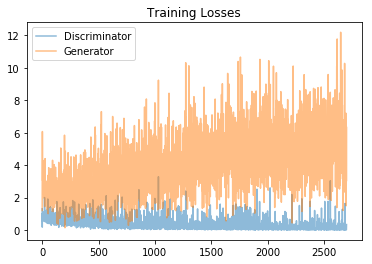

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

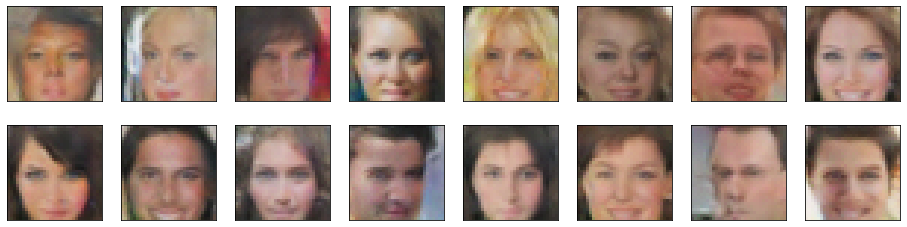

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** As stated above,the first thing that stands out is that the dataset consists of mostly white celebritites, so most of the generated faces are white. A simple solution to improve this would be to have a more racially balanced dataset, which could improve the results. For a better solution, I expect that the model architecture would have to be adjusted as well to account for race. 

Though a lot of faces look realisting, I'm noticing that there are issues if people are not looking straight into the camera and the faces are distoreted. A solution for that would be to have a larger dataset of faces, that is well balanced between people looking straight into the camera and photos of people from different angles. Also, having a larger image size would help, as I think including head position and hair in the image might help the model understand at what angle the head is located, which would help with generating less distorted faces. 

My model trained relatively fast, so I think increading the dataset size and the image size would benefit the generation of faces. My generated faces are also a slightly worse quality than the original pictures, so having larger image sizes might help improve the generated image quality.

I trained for 30 epochs, which was relatively fast. Some of the generated faces seem realistic, but some have issues. I'd say 30 epochs is a good number for okay images. Training for longer -- time permitting -- could generate less of the distorted faces.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.